<font color="#006400" face="sans-serif" size="7">
<b>Erika Shrestha</b>
</font>
<BR>
<font color="#006400" face="sans-serif" size="4.5">
<b>London Met ID: 23048598</b>
</font>

---


<b>FindCite is a text classification model that automatically classify citations in scientific research papers according to their purpose. This project aims to compare baseline model (Logistic Regression) and advanced model (SciBERT) to validate their adaptability and limitations.</b>

In [1]:
#INSTALL necessary librabries that are not by-default stored in golab
#!pip install --upgrade transformers

---
---

# **TEMPORARY DATA LOAD**
This notebook is designed to be fully reproducible in Google Colab.
Please ensure the setup cells (dataset download and folder creation) are run sequentially before executing the rest of the notebook.

---
---

In [2]:
#CREATE an empty folder in colab temporary files
!mkdir -p data

In [3]:
#CONNECT the data files which contains train, test and validation
!wget https://ai2-s2-research.s3-us-west-2.amazonaws.com/scicite/scicite.tar.gz

--2026-01-20 03:49:10--  https://ai2-s2-research.s3-us-west-2.amazonaws.com/scicite/scicite.tar.gz
Resolving ai2-s2-research.s3-us-west-2.amazonaws.com (ai2-s2-research.s3-us-west-2.amazonaws.com)... 3.5.84.0, 3.5.81.224, 52.92.136.2, ...
Connecting to ai2-s2-research.s3-us-west-2.amazonaws.com (ai2-s2-research.s3-us-west-2.amazonaws.com)|3.5.84.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23189911 (22M) [application/x-tar]
Saving to: ‘scicite.tar.gz’

scicite.tar.gz      100%[===================>]  22.12M  8.75MB/s    in 2.5s    

2026-01-20 03:49:13 (8.75 MB/s) - ‘scicite.tar.gz’ saved [23189911/23189911]



In [4]:
#EXTRACT the connected taz file
!tar -xvzf scicite.tar.gz

scicite/
scicite/train.jsonl
scicite/scaffolds/
scicite/test.jsonl
scicite/dev.jsonl
scicite/scaffolds/cite-worthiness-scaffold-train.jsonl
scicite/scaffolds/sections-scaffold-train.jsonl


In [5]:
#MOVE the required json files into the created data folder
!mv scicite/train.jsonl scicite/dev.jsonl scicite/test.jsonl data/

-------
-------

# **Let's Get Started**

In [6]:
#IMPORT all the necessary libraries used in the project
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import re
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from wordcloud import WordCloud
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
from scipy.special import softmax
from tf_keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc
from statsmodels.stats.contingency_tables import mcnemar
import joblib
from google.colab import files
import warnings
warnings.filterwarnings("ignore")

# **HELPER METHODS**

In [7]:
#FUNCTION to plot word cloud
def plot_wordcloud_per_class(X_texts, y_labels, title="Word Cloud"):
  classes = sorted(set(y_labels))
  fig, axes = plt.subplots(1, len(classes), figsize=(18, 6))

  for ax, cls in zip(axes, classes):
      text = " ".join(X_texts[y_labels == cls])

      wc = WordCloud(
          background_color="white",
          max_words=200,
          width=800,
          height=400
      )

      wc.generate(text)
      ax.imshow(wc, interpolation="bilinear")
      ax.set_title(f"{title} – Class {cls}")
      ax.axis("off")

  plt.tight_layout()
  plt.show()

In [8]:
#FUNCTION to plot learning curve to check overfitting and underfitting
def plot_learning_curve(model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5), scoring='f1_macro', title="Learning Curve"):

  train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, train_sizes=train_sizes, scoring=scoring, n_jobs=-1
    )

  plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', color='blue', label='Training Score')
  plt.plot(train_sizes, val_scores.mean(axis=1), marker='s', color='purple', label='Validation Score')
  plt.xlabel('Training Size')
  plt.ylabel('F1 Score')
  plt.title(f'{title} Learning Curve')
  plt.legend()
  plt.show()

In [9]:
#FUNCTION to plot confusion matrix to check model predictions accuracy
def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix", cmap='Blues'):

  class_names = ['Background', 'Method', 'Result']

  cm = confusion_matrix(y_true, y_pred, labels=labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

  disp.plot(cmap=cmap, xticks_rotation=45)
  plt.title(title)
  plt.show()

In [10]:
#FUNCTION to plot PR curve to check model actual performance and not just accuracy
def plot_precision_recall_curve(y_true, y_scores, title="Precision-Recall Curve"):

    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)

    plt.figure(figsize=(8, 6))
    colors = ['purple', 'blue', 'yellow']

    for i, cls in enumerate(classes):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
        auc_score = auc(recall, precision)
        plt.plot(recall, precision, color=colors[i], label=f'Class {cls} (AUC={auc_score:.2f})')

    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.title(f'{title} PR Curve')
    plt.legend()
    plt.grid(False)
    plt.show()

In [11]:
#FUNCTION to plot ROC-AUC curve to check one vs rest
def plot_roc_auc_curve(y_true, y_scores, class_names=None, title="ROC-AUC Curve"):
    classes = np.unique(y_true)
    y_bin = label_binarize(y_true, classes=classes)

    plt.figure(figsize=(8,6))
    colors = ['purple', 'blue', 'yellow']

    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_scores[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], label=f'Class {class_names[i]} (AUC={auc_score:.2f})')

    # Random classifier baseline
    plt.plot([0,1], [0,1], 'k--', label='Random')

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid(False)
    plt.show()


In [12]:
#FUNCTION to plot scibert history behavior based on metrics: loss and accuracy
def plot_history(history, metric='loss', title="Training vs Validation"):

    plt.figure(figsize=(8,6))
    plt.plot(history.history[metric], label=f'Train {metric}', marker='o', color='blue')
    plt.plot(history.history['val_' + metric], label=f'Val {metric}', marker='s', color='purple')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.title(f'{title} {metric}')
    plt.legend()
    plt.grid(False)
    plt.show()

----
----

# **EXPLORATORY DATA ANALYSIS (EDA)** 📊

**The original Scicite dataset provides separate train, development, and test splits. For understanding the characteristics of the datasets, the train, test and development sets were concatenated to form a larger labeled dataset while test sets is carefully examined due to absence of 1 column (label_confidence)**

In [13]:
#IMPORT training data from data Folder
train_df = pd.read_json('data/train.jsonl', lines=True)
#head() shows only 5 documents by default
train_df.head()

,source,citeEnd,sectionName,citeStart,string,label,label_confidence,citingPaperId,citedPaperId,isKeyCitation,id,unique_id,excerpt_index,label2,label2_confidence
0,explicit,175.0,Introduction,168.0,"However, how frataxin interacts with the Fe-S ...",background,1.0,1872080baa7d30ec8fb87be9a65358cd3a7fb649,894be9b4ea46a5c422e81ef3c241072d4c73fdc0,True,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,11,NaN,NaN
1,explicit,36.0,Novel Quantitative Trait Loci for Seminal Root...,16.0,"In the study by Hickey et al. (2012), spikes w...",background,1.0,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b,b6642e19efb8db5623b3cc4eef1c5822a6151107,True,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,2,NaN,NaN
2,explicit,228.0,Introduction,225.0,"The drug also reduces catecholamine secretion,...",background,1.0,9cdf605beb1aa1078f235c4332b3024daa8b31dc,4e6a17fb8d7a3cada601d942e22eb5da6d01adbd,False,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,0,NaN,NaN
3,explicit,110.0,Discussion,46.0,By clustering with lowly aggressive close kin ...,background,1.0,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,False,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,3,NaN,NaN
4,explicit,239.0,Discussion,234.0,Ophthalmic symptoms are rare manifestations of...,background,1.0,88b86556857f4374842d2af2e359576806239175,a5bb0ff1a026944d2a47a155462959af2b8505a8,False,88b86556857f4374842d2af2e359576806239175>a5bb0...,88b86556857f4374842d2af2e359576806239175>a5bb0...,2,NaN,NaN


In [14]:
#IMPORT testing data from data Folder
test_df = pd.read_json('data/test.jsonl', lines=True)
#head() shows only 5 documents by default
test_df.head()

,source,citeEnd,sectionName,citeStart,string,label,citingPaperId,citedPaperId,isKeyCitation,id,unique_id,excerpt_index,label2,label_confidence
0,acronym,31.0,,28.0,"Chapel, as well as X10 [2], UPC [3] , CoArray ...",background,2c6797dab4c118cb73197f65ba39dacc99ac743d,95c37bc99982d33873fd141ee00857160fd717a0,True,2c6797dab4c118cb73197f65ba39dacc99ac743d>95c37...,2c6797dab4c118cb73197f65ba39dacc99ac743d>95c37...,6,NaN,NaN
1,explicit,166.0,Discussion,156.0,"In addition, the result of the present study s...",result,fa7145adc9f8cfb8af7a189d9040c13c84ced094,20e23b4f76761d246a7c3b00b80e139e2008f77d,False,fa7145adc9f8cfb8af7a189d9040c13c84ced094>20e23...,fa7145adc9f8cfb8af7a189d9040c13c84ced094>20e23...,0,supportive,NaN
2,explicit,145.0,Discussion,137.0,Several instruments that more specifically add...,background,98a8d8c0c5dae246720d4f339b88e8a9f44e3002,bd222c7ec83dadefba513738290b3624f6dd6b21,True,98a8d8c0c5dae246720d4f339b88e8a9f44e3002>bd222...,98a8d8c0c5dae246720d4f339b88e8a9f44e3002>bd222...,1,NaN,NaN
3,explicit,158.0,Methods,137.0,Organotypic hippocampal slice cultures\nInterf...,method,aeb178ef1910a61152cd74209c28641199c82855,754c04953c261072fa367f4104e3deff082d9484,False,aeb178ef1910a61152cd74209c28641199c82855>754c0...,aeb178ef1910a61152cd74209c28641199c82855>754c0...,1,NaN,1.0
4,explicit,186.0,RESULTS,178.0,Activated PBMC are the basis of the standard P...,background,e4d2591ac3bb65e2ec59f092884a7b15b8018592,f0fb468a54fe8021bc7986a1618222c4fcd16df4,False,e4d2591ac3bb65e2ec59f092884a7b15b8018592>f0fb4...,e4d2591ac3bb65e2ec59f092884a7b15b8018592>f0fb4...,6,NaN,NaN


In [15]:
#IMPORT validation data from data Folder
val_df = pd.read_json('data/dev.jsonl', lines=True)
#head() shows only 5 documents by default
val_df.head()

,source,citeEnd,sectionName,citeStart,string,label,label2,citingPaperId,citedPaperId,isKeyCitation,id,unique_id,excerpt_index,label_confidence,label2_confidence
0,explicit,68.0,Discussion,64.0,These results are in contrast with the finding...,result,supportive,8f1fbe460a901d994e9b81d69f77bfbe32719f4c,5e413c7872f5df231bf4a4f694504384560e98ca,False,8f1fbe460a901d994e9b81d69f77bfbe32719f4c>5e413...,8f1fbe460a901d994e9b81d69f77bfbe32719f4c>5e413...,0,NaN,NaN
1,explicit,241.0,Discussion,222.0,…nest burrows in close proximity of one anothe...,background,NaN,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,False,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,10,0.7337,NaN
2,explicit,94.0,. 6 Discussion,71.0,This is clearly in contrast to the results of ...,result,supportive,226f798d30e5523c5b9deafb826ddb04d47c11dc,None,False,226f798d30e5523c5b9deafb826ddb04d47c11dc>None,226f798d30e5523c5b9deafb826ddb04d47c11dc>None_0,0,NaN,NaN
3,explicit,170.0,,148.0,"…in a subset of alcoholics (Chen et al., 2004;...",background,NaN,59dba7cd80edcce831d20b35f9eb597bba290154,273996fbf99465211eb8306abe8c56c5835f332e,False,59dba7cd80edcce831d20b35f9eb597bba290154>27399...,59dba7cd80edcce831d20b35f9eb597bba290154>27399...,0,1.0000,NaN
4,explicit,89.0,DISCUSSION,85.0,This result is consistent with the conclusions...,result,not_supportive,0640f6e098a9d241cd680473e8705357ae101e04,e33da0584b8db37816d510fd9ba7c1216858fd5f,False,0640f6e098a9d241cd680473e8705357ae101e04>e33da...,0640f6e098a9d241cd680473e8705357ae101e04>e33da...,0,NaN,NaN


In [16]:
#CONCATINATE train and validation sets
explore_df = pd.concat([train_df, val_df, test_df])
explore_df

,source,citeEnd,sectionName,citeStart,string,label,label_confidence,citingPaperId,citedPaperId,isKeyCitation,id,unique_id,excerpt_index,label2,label2_confidence
0,explicit,175.0,Introduction,168.0,"However, how frataxin interacts with the Fe-S ...",background,1.0,1872080baa7d30ec8fb87be9a65358cd3a7fb649,894be9b4ea46a5c422e81ef3c241072d4c73fdc0,True,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,11,NaN,NaN
1,explicit,36.0,Novel Quantitative Trait Loci for Seminal Root...,16.0,"In the study by Hickey et al. (2012), spikes w...",background,1.0,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b,b6642e19efb8db5623b3cc4eef1c5822a6151107,True,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,2,NaN,NaN
2,explicit,228.0,Introduction,225.0,"The drug also reduces catecholamine secretion,...",background,1.0,9cdf605beb1aa1078f235c4332b3024daa8b31dc,4e6a17fb8d7a3cada601d942e22eb5da6d01adbd,False,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,0,NaN,NaN
3,explicit,110.0,Discussion,46.0,By clustering with lowly aggressive close kin ...,background,1.0,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,False,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,3,NaN,NaN
4,explicit,239.0,Discussion,234.0,Ophthalmic symptoms are rare manifestations of...,background,1.0,88b86556857f4374842d2af2e359576806239175,a5bb0ff1a026944d2a47a155462959af2b8505a8,False,88b86556857f4374842d2af2e359576806239175>a5bb0...,88b86556857f4374842d2af2e359576806239175>a5bb0...,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,explicit,155.0,4. Discussion,136.0,"Additionally, no sex differences were detected...",result,NaN,3cf9c7cd259a356839f42ecf143af3a8f6ef8b54,74cbd6d0eeb051b036f806d8a86c3a85859f9d7d,False,3cf9c7cd259a356839f42ecf143af3a8f6ef8b54>74cbd...,3cf9c7cd259a356839f42ecf143af3a8f6ef8b54>74cbd...,0,supportive,NaN
1857,explicit,188.0,3. Discussion,184.0,WBRT (40Gy in 20 fractions) along with concurr...,background,NaN,e609824e9ea6bee5aca817238d81d1cdd6b462ad,f7bfdcf8892a561b6030ed541924551fb78acf1f,False,e609824e9ea6bee5aca817238d81d1cdd6b462ad>f7bfd...,e609824e9ea6bee5aca817238d81d1cdd6b462ad>f7bfd...,1,NaN,NaN
1858,explicit,110.0,Methods,103.0,The data obtained from this crosssectional sur...,method,NaN,19317f7188bc6ecad985c46277969c0ac03dbcf8,0c86f0d577f04534edc14a509a68ae80ce6fbb74,False,19317f7188bc6ecad985c46277969c0ac03dbcf8>0c86f...,19317f7188bc6ecad985c46277969c0ac03dbcf8>0c86f...,0,NaN,NaN
1859,explicit,360.0,Discussion,321.0,"Additionally, encapsulated spheroids may be mu...",background,NaN,62ac94ab9227b84f1317edad1b6312e311981961,df5084196ea93af9250fae27c981ea3d7959599d,False,62ac94ab9227b84f1317edad1b6312e311981961>df508...,62ac94ab9227b84f1317edad1b6312e311981961>df508...,1,NaN,NaN


**The individual dataset splits were first concatenated into a single dataframe with a shape of (11020 x 15) to facilitate unified preprocessing and exploratory data analysis (EDA).**

----
----

# **Data Quality Check** ☑️

1.   Missing Values Check
2.   Data Type Consistency
3.   Duplication Check
4.   Label Distribution
5.   Text Length Distribution


---
---

#####**1. Missing Values Check**

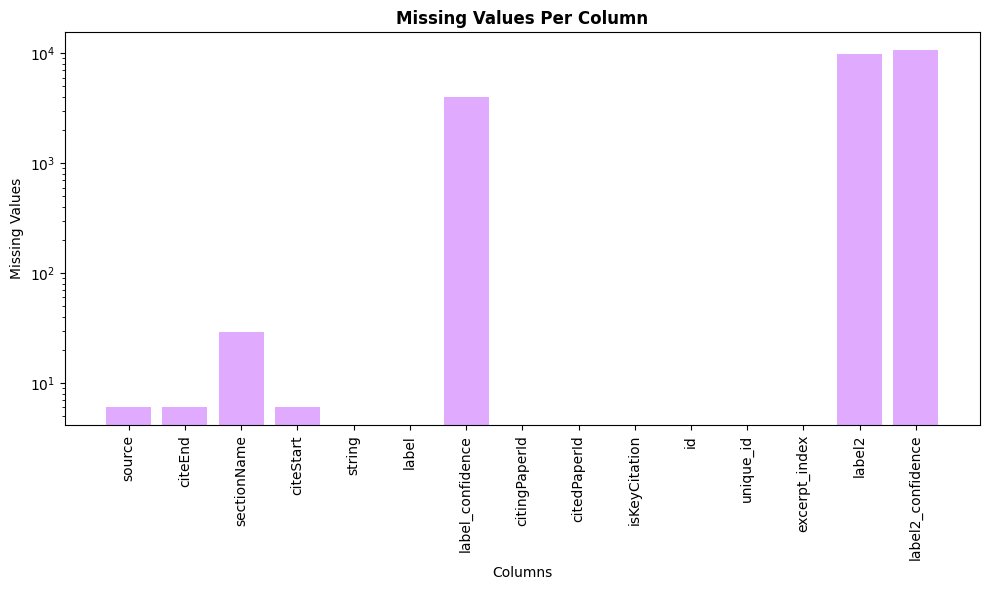

In [17]:
#CHECKS the missing values of all the columns in the findcite_df
#logarithm scaling is used for y-axis to visualize columns with large gap in missing values
missing_counts = explore_df.isnull().sum()
plt.figure(figsize=(10,6))
plt.bar(missing_counts.index, missing_counts.values, color='#E0AAFF')
plt.yscale('log')
plt.title('Missing Values Per Column', fontweight='bold')
plt.xticks(rotation=90)
plt.ylabel('Missing Values')
plt.xlabel('Columns')
plt.tight_layout()

In [18]:
#CHECKS whether there is presence of high missing values (case = missing_values > 50%)
total_rows = len(explore_df)
missing_percent_per_columns = ((missing_counts / total_rows) * 100).round(1)
missing_percent_per_columns

,0
source,0.1
citeEnd,0.1
sectionName,0.3
citeStart,0.1
string,0.0
label,0.0
label_confidence,36.3
citingPaperId,0.0
citedPaperId,0.0
isKeyCitation,0.0


**Eight columns have no missing values, which means the core data is complete and reliable. A few columns such as source, citeStart, citeEnd, and sectionName have only a small number of missing entries so they are not a major issue.**

**However, the columns label_confidence, label2, and label2_confidence have a very large number of missing values. This means secondary labels and their confidence scores are mostly unavailable and may not be useful to perform multi label classification.**

---
---

#####**2. Data Type Consistency**

In [19]:
#CHECKS data types for each dataframes
print(f"\033[1mTrain sets data types:\033[0m\n{train_df.dtypes}\n")
print(f"\033[1mValidation sets data types:\033[0m\n{val_df.dtypes}\n")
print(f"\033[1mTest sets data types:\033[0m\n{test_df.dtypes}\n")

Train sets data types:
source                object
citeEnd              float64
sectionName           object
citeStart            float64
string                object
label                 object
label_confidence     float64
citingPaperId         object
citedPaperId          object
isKeyCitation           bool
id                    object
unique_id             object
excerpt_index          int64
label2                object
label2_confidence    float64
dtype: object

Validation sets data types:
source                object
citeEnd              float64
sectionName           object
citeStart            float64
string                object
label                 object
label2                object
citingPaperId         object
citedPaperId          object
isKeyCitation           bool
id                    object
unique_id             object
excerpt_index          int64
label_confidence     float64
label2_confidence    float64
dtype: object

Test sets data types:
source               object

**According to the information, All the data types are consistent.**

----
----

#####**3. Duplication Check**

In [20]:
#SHOWS all the duplicate document in the dataframe through keep=false
duplicates = explore_df[explore_df.duplicated(keep=False)]
print(duplicates.to_string())

     source  citeEnd sectionName  citeStart                                                                                                                                                                                                                                                                                    string   label  label_confidence                             citingPaperId                              citedPaperId  isKeyCitation                                                                                 id                                                                            unique_id  excerpt_index          label2  label2_confidence
4378   None      NaN  DISCUSSION        NaN  PFC patients and controls did not differ with respect to the amount of time spent making the first move on each tower, a finding consistent with previous studies (Andres & Van der Linden, 2001; Goel & Grafman, 1995; Jacobs & Anderson, 2002; Owen et al., 1990; Rushe et al., 1999).  resu

The **4378** and **503** rows were found to have same entries for every columns.

In [21]:
#REMOVES the duplicated document but keeps the first occurrence
explore_df = explore_df.drop_duplicates(keep='first')

In [22]:
#CROSS CHECKING the removal of duplicates
explore_df.duplicated().sum()

np.int64(0)

**After finding a duplicate document in the dataframe, we remove but keep the first occurring document.**

----
----

#####**4. Label Distribution**

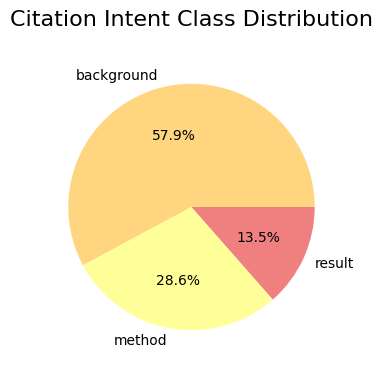

In [23]:
#CALCULATES total occurrence for each classes to check class imbalance
class_counts = explore_df['label'].value_counts()
plt.figure(figsize=(4,4))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=['#FFD580','#FFFF99','#F08080'])
plt.title('Citation Intent Class Distribution', fontsize=16, pad=20)
plt.show()

Upon calculation results, we see that the classes are distributed unevenly in label columns indicating class imbalance where **background** label has **58.7%** dominance, followed by **method** with **27.8%** and **result** with just **13.5%** which may bias the model toward the majority class (i.e. Background).

---
---

#####**5. Text Length Distribution**

In [24]:
#FINDS the text length in string column for each row
text_lengths = explore_df['string'].str.len()
#GROUPS the extracted text length by label and calculates the average through mean()
avg_length = text_lengths.groupby(explore_df['label']).mean()

In [25]:
#ROUNDS UP the value to 1
avg_length.round(1)

,string
label,
background,217.9
method,217.4
result,240.6


**This check is done to ensure that differences in text length between classes do not unfairly influence the model performance. This ensures that the model should focus on semantic meaning rather than length.**

----
----

# **Feature Selection** 🔎

**Before training the model, it is essential to identify and retain only the most relevant features and target variables from the dataset. Since the focus of this project is text classification selection of only the column containing the citation sentences as the feature and the column containing the citation intent labels as the target.**

In [26]:
#PERFORM Feature Selection for explore_df by copying selected features into new dataframe
findcite_df = explore_df[['string', 'label']].copy()
findcite_df

,string,label
0,"However, how frataxin interacts with the Fe-S ...",background
1,"In the study by Hickey et al. (2012), spikes w...",background
2,"The drug also reduces catecholamine secretion,...",background
3,By clustering with lowly aggressive close kin ...,background
4,Ophthalmic symptoms are rare manifestations of...,background
...,...,...
1856,"Additionally, no sex differences were detected...",result
1857,WBRT (40Gy in 20 fractions) along with concurr...,background
1858,The data obtained from this crosssectional sur...,method
1859,"Additionally, encapsulated spheroids may be mu...",background


----
----

# **DATA SPLIT** 📑

**The dataset is divided into training and test sets with 80-20 ratio. The training set is further partitioned to perform cross validation resulting in three distinct subsets: Train, Validation, and Test. This split ensures that the model can learn from the training data, tune hyperparameters using the validation set, and be evaluated on an unseen test set to provide an unbiased assessment of its performance. Stratification is applied during splitting to preserve the original class distribution across all subsets which is particularly important for multi-class classification tasks.**

In [27]:
#DEFINES X (Features) and y (Target)
X = findcite_df['string']
y = findcite_df['label']

In [28]:
#SPLITS train and tests with stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

---
---

# **Text Preprocessing** 🔤

1.   Tokenization
2.   Text Removal (lower casing, punctuation removal, characters removal, space parsing removal, stopwords removal)
3.   Lemmatization

In [29]:
#DOWNLOADS NLTK resources required for text preprocessing
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [30]:
#INITIALIZES the list of English stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [31]:
#FUNCTION to preprocess string columns into cleaned texts for logistic regression model training
def preprocess_text_for_logreg(text):

    #TOKENIZES
    words = text.split()

    #REMOVES space sparse
    cleaned_words = []
    for word in words:
        word = word.strip()
        if word != '':
            cleaned_words.append(word)

    #CONVERTS to lowercase
    lowercase_words = []
    for word in cleaned_words:
        lowercase_words.append(word.lower())

    #REMOVES stopwords
    filtered_words = []
    for word in lowercase_words:
        if word not in stop_words:
            filtered_words.append(word)

    #LEMMATIZES
    lemmatized_words = []
    for word in filtered_words:
        lemma = lemmatizer.lemmatize(word)
        lemmatized_words.append(lemma)

    #STORES back to strings
    cleaned_text = ' '.join(lemmatized_words)

    return cleaned_text

In [32]:
#APPLIES preprocessing function for logistic regression
X_train_lr = X_train.apply(preprocess_text_for_logreg)
X_test_lr  = X_test.apply(preprocess_text_for_logreg)

In [33]:
#FUNCTION to preprocess string columns into cleaned texts for scibert model training
def preprocess_text_for_scibert(text):

    #REMOVES space sparse
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    return text

In [34]:
#APPLIES preprocessing function for scibert
X_train_scibert = X_train.apply(preprocess_text_for_scibert)
X_test_scibert  = X_test.apply(preprocess_text_for_scibert)

**The data is preprocessed differently depending on the model. For Logistic Regression, the text is cleaned by removing extra spaces, lowercased, stopwords removed and lemmatized. For SciBERT, only leading and trailing spaces are removed since the model can handle raw scientific text on its own.**

## **WORD CLOUDS** ☁️

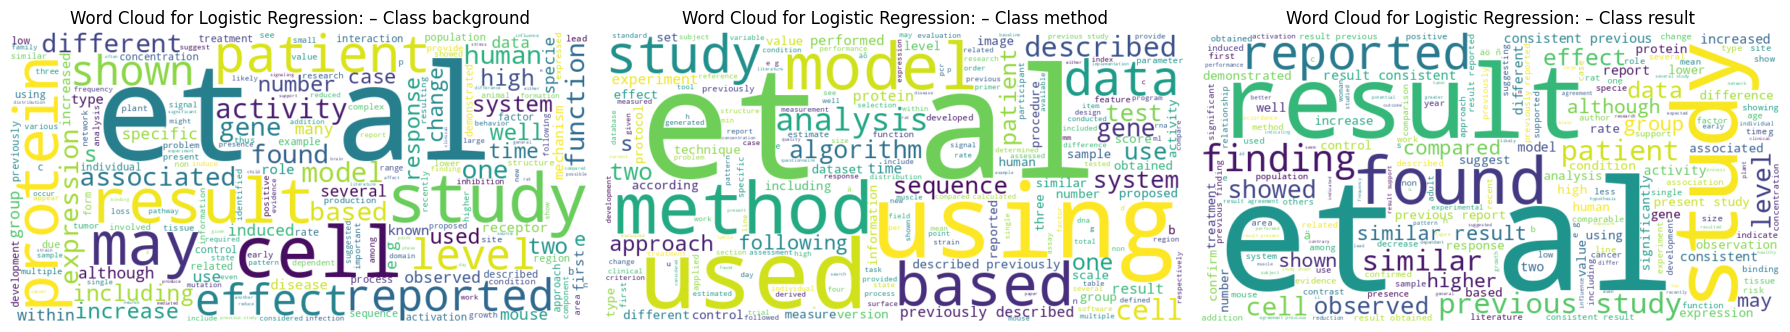

In [35]:
#SHOWS word cloud for logistic regression
plot_wordcloud_per_class(X_train_lr, y_train, title="Word Cloud for Logistic Regression:")

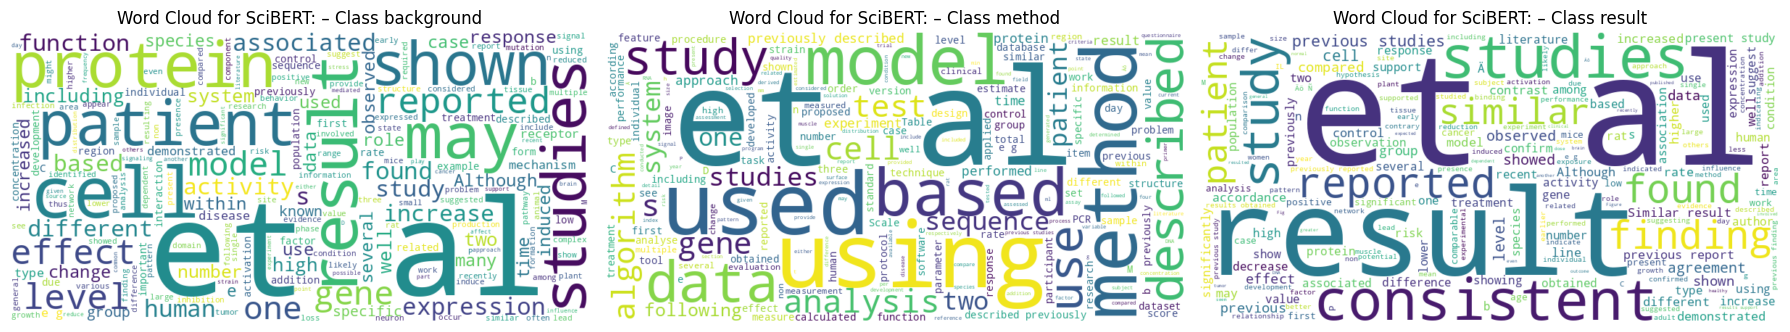

In [36]:
#SHOWS word cloud for sciBERT
plot_wordcloud_per_class(X_train_scibert, y_train, title="Word Cloud for SciBERT:")

----
----

# **Target Preprocessing** 🎯

In [37]:
#CONVERTS labels into label numberings
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

**It converts the labels (Target) into categorical encoding like 0, 1 and 2.**

---
---

# **Model Training** 🤖

**In this section, we train two different models to classify the citation intent to compare their performances. Apart from just performance comparison, experimental analysis through hyperparameter tuning on the baseline models is also done handling real-life scenarios and not just to focus on accuracy but identified class imbalances and future occuring overfits.**

---

#####**1. TF-IDF + Logistic Regression**

**A multinomial Logistic Regression model (with Softmax activation) is then trained on the TF-IDF features to predict the probability of each citation intent class.**

In [38]:
#CREATES pipeline to perform TF-IDF to only the preprocessed training set avoiding data leakage
logreg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

In [39]:
#TRAINS the model using the pipeline
logreg_pipeline.fit(X_train_lr, y_train_enc)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', LogisticRegression(max_iter=1000, random_state=42))])

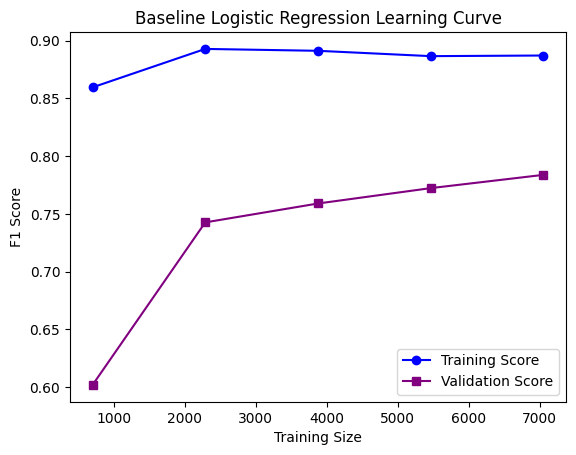

In [40]:
#SHOWS training and validation scores for baseline model training behavior
plot_learning_curve(
    logreg_pipeline,
    X_train, y_train,
    cv=5,
    scoring='f1_macro',
    title="Baseline Logistic Regression"
)

In [41]:
#PREDICTIONS of trained baseline model
y_pred = logreg_pipeline.predict(X_test_lr)

In [42]:
#SHOWS classification report
print(classification_report(y_test_enc, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85      1275
           1       0.81      0.65      0.72       631
           2       0.86      0.58      0.69       298

    accuracy                           0.80      2204
   macro avg       0.82      0.72      0.76      2204
weighted avg       0.80      0.80      0.79      2204



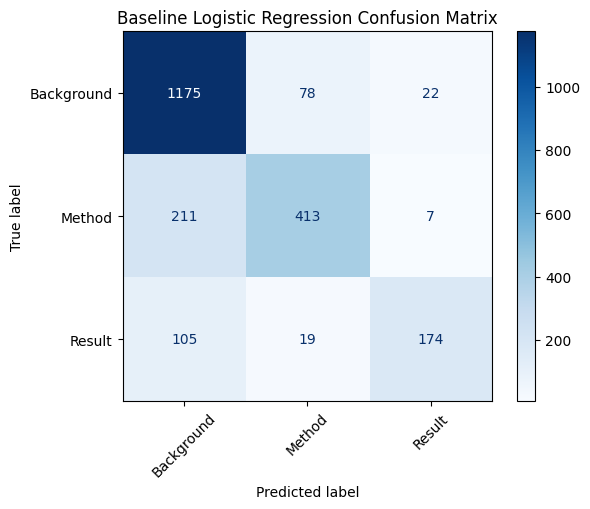

In [43]:
#SHOWS confusion matrix
plot_confusion_matrix(
    y_test_enc,
    y_pred,
    labels=logreg_pipeline.classes_,
    title="Baseline Logistic Regression Confusion Matrix"
)

**For the baseline Logistic Regression model, we use a simple train/test split to evaluate performance using default settings. Here, we can see the baseline model performs exceptionally nice with macro F1-score of 76% and accuracy of 80%. However, the model shows a clear sign of overfitting with start off difference of approximately 25%. Also, the macro F1-score is basically influenced by the majority class whereas the recall performance for minority classes is not seen to be very good. Keeping these observations in mind, it is evident that while the baseline Logistic Regression gives a reasonable overall performance, issues such as overfitting and lower recall for minority classes need to be addressed.**

---

#####**Hyperparameter tuning**

The hyperparameter tuning techniques used in order to address the issue are:

1. Grid Search cv 🗳️
2. Class weights ⚖️

In [44]:
#ADDS class weight = 'balanced' to address the minority classes and have a balanced result
tuned_logreg_pipeline = Pipeline([
  ('tfidf', TfidfVectorizer()),
  ('clf', LogisticRegression(
      max_iter=1000,
      class_weight = 'balanced',
      random_state=42
  ))
])

In [45]:
#INITIALIZES each fold has roughly the same class proportions as the whole dataset
skf = StratifiedKFold(
  n_splits=5,
  shuffle=True,
  random_state=42
)

In [46]:
#SELECTS appropriate candidates for the best grid search combination
param_grid = {
    'tfidf__max_features': [3000, 4000, 6000],
    'clf__C': [0.005, 0.01, 0.03, 0.05, 0.1],
    'tfidf__ngram_range': [(1, 1),(1,2)],
    'tfidf__min_df': [5, 10]
}

In [47]:
#RETRIEVES scorings of F1-score since accuracy can be misleading
scoring = {
    'f1_macro': 'f1_macro',
    'f1_micro': 'f1_micro',
    'f1_weighted': 'f1_weighted'
}

In [48]:
#PERFORMS hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(
    tuned_logreg_pipeline,
    param_grid,
    cv=skf,
    scoring=scoring,
    refit='f1_macro',
    verbose=2
)

In [49]:
#TRAINS and DISPLAYS the best hyperparameter combination and the best macro-F1 score achieved
grid_search.fit(X_train_lr, y_train_enc)
print("The best settings are:", grid_search.best_params_)
print("The best F1 Score reached:", grid_search.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END clf__C=0.005, tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   0.5s
[CV] END clf__C=0.005, tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   0.5s
[CV] END clf__C=0.005, tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   0.4s
[CV] END clf__C=0.005, tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   0.5s
[CV] END clf__C=0.005, tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   0.5s
[CV] END clf__C=0.005, tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   1.9s
[CV] END clf__C=0.005, tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   1.7s
[CV] END clf__C=0.005, tfidf__max_features=3000, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   0.7s
[CV] END clf__C=0.005, tfidf__max_features

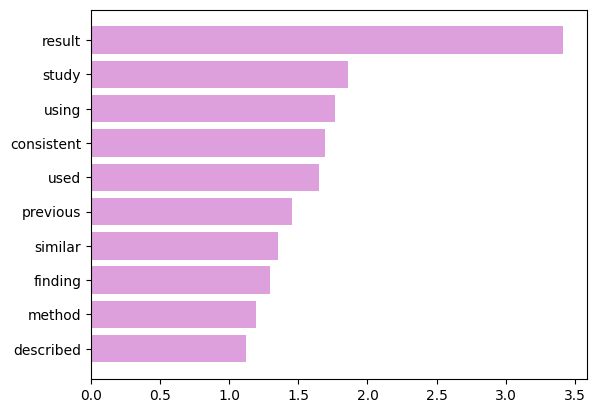

In [50]:
#PLOTS top TF-IDF features
feat = grid_search.best_estimator_.named_steps['tfidf'].get_feature_names_out()
imp  = grid_search.best_estimator_.named_steps['clf'].coef_

top = np.argsort(np.mean(np.abs(imp), axis=0))[-10:]

plt.barh(feat[top], np.mean(np.abs(imp), axis=0)[top], color='plum')
plt.show()

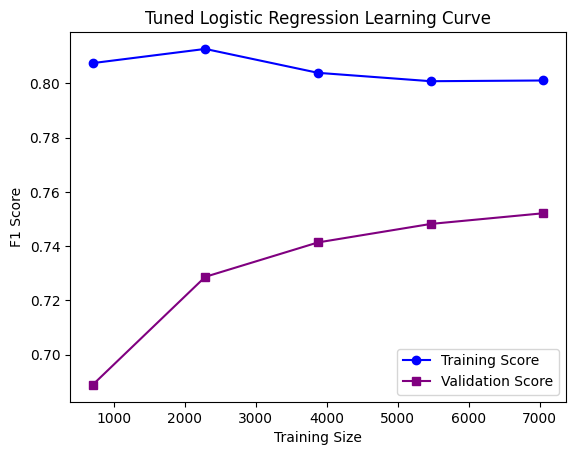

In [51]:
#SHOWS training and validation scores for model training behavior
plot_learning_curve(
    model=grid_search.best_estimator_,
    X=X_train_lr,
    y=y_train_enc,
    cv=5,
    scoring='f1_macro',
    title="Tuned Logistic Regression"
)

In [52]:
#CHECKS model convergence
grid_search.best_estimator_.named_steps['clf'].n_iter_

array([24], dtype=int32)

**The model has learned as much as it can from the training data since it converges at 24 steps.**

In [53]:
#PREDICTS using the best estimator
y_pred= grid_search.best_estimator_.predict(X_test_lr)
y_proba = grid_search.best_estimator_.predict_proba(X_test_lr)
confidence = np.max(y_proba, axis=1)

In [54]:
#SHOWS classification report
print(classification_report(y_test_enc, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1275
           1       0.73      0.77      0.75       631
           2       0.63      0.78      0.70       298

    accuracy                           0.78      2204
   macro avg       0.74      0.78      0.76      2204
weighted avg       0.79      0.78      0.78      2204



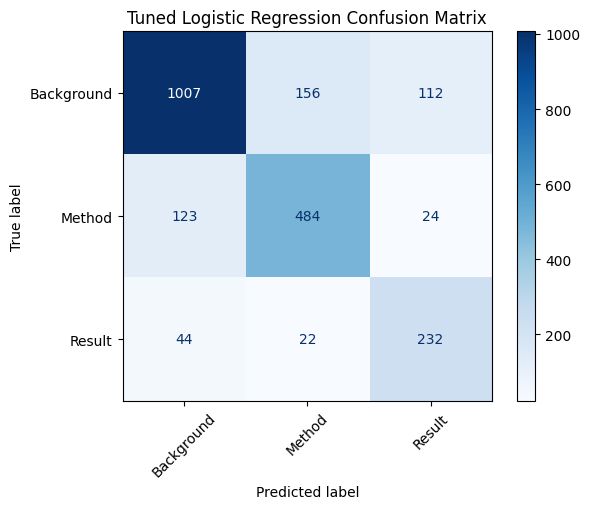

In [55]:
#SHOWS confusion matrix
plot_confusion_matrix(
    y_test_enc,
    y_pred,
    labels=grid_search.best_estimator_.classes_,
    title="Tuned Logistic Regression Confusion Matrix"
)

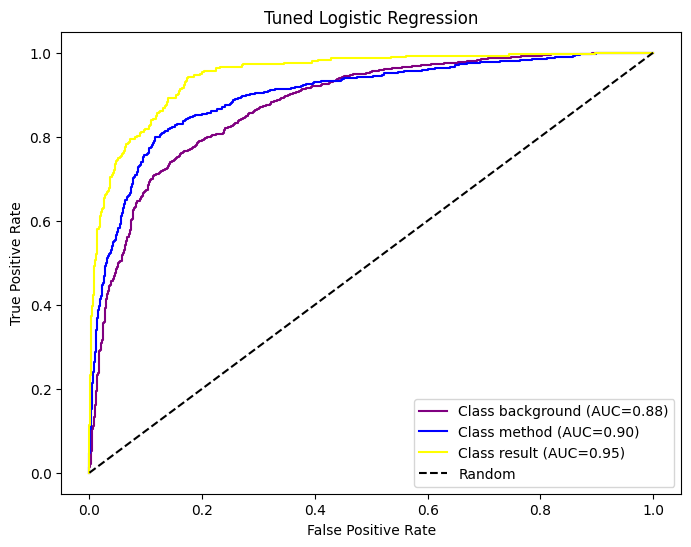

In [56]:
#SHOWS the one vs rest ROC-AUC curve
y_scores_lr = grid_search.best_estimator_.predict_proba(X_test_lr)
plot_roc_auc_curve(y_test_enc, y_scores_lr, class_names=le.classes_, title="Tuned Logistic Regression")

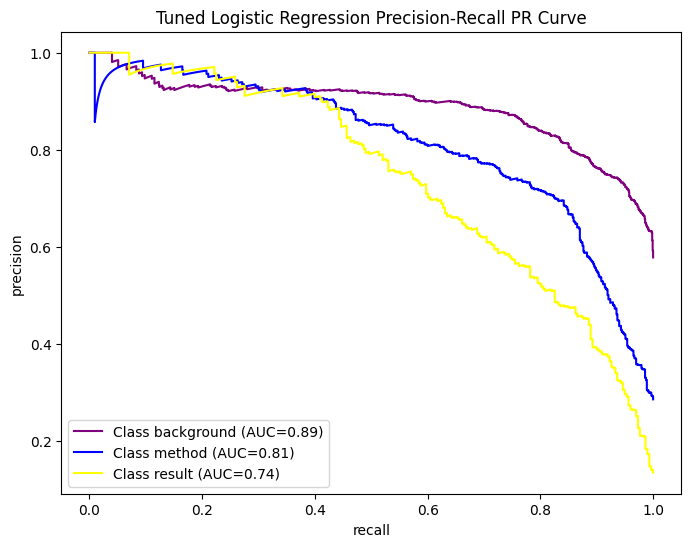

In [57]:
#SHOWS the one vs rest PR curve
y_scores_lr = grid_search.best_estimator_.predict_proba(X_test)
plot_precision_recall_curve(y_test_enc, y_scores_lr, title="Tuned Logistic Regression Precision-Recall")

**The training and validation scores are much closer together with only 4% gap. The validation score rises to approximately 0.75-0.79, converging more tightly with the training line. In addition, even though the accuracy has decreased from 80% to 79%, the F1-scores for each classes have increased. Since the data is imbalanced, the priority lies to macro f1-score more than accuracy.**

**The baseline model was clearly showing signs of overfitting as training score reached to ~ 89% but the model achieved only 80% whereas on the hyperparameter tuned model the training score and test score was closer being 80% to 78%.**


---

**ADDITIONAL PERFORMANCE METRICS USING GRID SEARCH**

In [58]:
#DISPLAYS best combination by ranks
full_results = pd.DataFrame(grid_search.cv_results_)
necessary_results = full_results[['params', 'mean_test_f1_macro', 'std_test_f1_macro', 'rank_test_f1_macro']]
necessary_results.sort_values(by='rank_test_f1_macro').head()

,params,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro
56,"{'clf__C': 0.1, 'tfidf__max_features': 6000, '...",0.752996,0.014401,1
57,"{'clf__C': 0.1, 'tfidf__max_features': 6000, '...",0.752699,0.011771,2
52,"{'clf__C': 0.1, 'tfidf__max_features': 4000, '...",0.751818,0.014050,3
53,"{'clf__C': 0.1, 'tfidf__max_features': 4000, '...",0.750941,0.013132,4
48,"{'clf__C': 0.1, 'tfidf__max_features': 3000, '...",0.750399,0.013718,5


In [59]:
#DISPLAYS the selected best combination metrics by each folds (K=5)
best_idx = grid_search.best_index_
for i in range(5):
    print(
        f"Fold {i+1} F1-macro:",
        grid_search.cv_results_[f'split{i}_test_f1_macro'][best_idx],
        " | F1-micro:",
        grid_search.cv_results_[f'split{i}_test_f1_micro'][best_idx],
        " | F1-weighted:",
        grid_search.cv_results_[f'split{i}_test_f1_weighted'][best_idx]
    )

Fold 1 F1-macro: 0.7708918581952878  | F1-micro: 0.7901304594441293  | F1-weighted: 0.7916747429621721
Fold 2 F1-macro: 0.7507208186728347  | F1-micro: 0.7759500850822462  | F1-weighted: 0.778996051639836
Fold 3 F1-macro: 0.7342928138716581  | F1-micro: 0.761769710720363  | F1-weighted: 0.7653515168046928
Fold 4 F1-macro: 0.7411786728732036  | F1-micro: 0.7595008508224617  | F1-weighted: 0.7619795757389171
Fold 5 F1-macro: 0.7678956868211516  | F1-micro: 0.7901304594441293  | F1-weighted: 0.7924334608162722


---
---

#####**2. SciBERT**

**SciBERT is atransformer-based language model specifically trained on scientific text. It captures contextual relationships and has own tokenizer unlike other traditional models.**

In [60]:
#DEFINES the model in use
scibert_model = "allenai/scibert_scivocab_uncased"
num_labels = 3

In [61]:
#LOADS tokenizer
tokenizer = AutoTokenizer.from_pretrained(scibert_model)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [62]:
#scibert = TFAutoModelForSequenceClassification.from_pretrained(scibert_model, num_labels=num_labels, from_pt=True)
scibert = TFAutoModelForSequenceClassification.from_pretrained(scibert_model, num_labels=num_labels, from_pt=True)

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
#FREEZES all layers except for the classification
for layer in scibert.layers:
    layer.trainable = False

scibert.classifier.trainable = True

In [64]:
#COMPUTE class weights to handle class imbalance for scibert
classes = np.unique(y_train_enc)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_enc)
class_weights_dict = dict(zip(classes, class_weights))

---

#####**VALIDATION SPLIT**

In [65]:
#SPLITS the training sets into another subset with validation set as 20% of it
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_scibert, y_train_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_train_enc
)

In [66]:
#USES scibert's own tokenizer to encode the sets
train_encodings = tokenizer(list(X_train_sub), truncation=True, padding=True, max_length=128, return_tensors='tf')
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, max_length=128, return_tensors='tf')
test_encodings = tokenizer(list(X_test_scibert), truncation=True, padding=True, max_length=128, return_tensors='tf')

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [67]:
#CONVERTS tokenized inputs into TensorFlow datasets and batch them for training, validation, and testing
batch_size=8
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train_sub
)).shuffle(1000).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test_enc
)).batch(batch_size)

In [68]:
#COMPILES the SciBERT model
scibert.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [69]:
#CREATES an early stop to avoid overfitting over epochs (currently it is not used since epochs are properly training if needed add in history as a callbacks=[early_stop])
early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=0,
    restore_best_weights=True
)

In [70]:
#TRAINS the SciBERT model
history = scibert.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    class_weight=class_weights_dict,
)

Epoch 1/5
882/882 [==============================] - 109s 107ms/step - loss: 0.7009 - accuracy: 0.6964 - val_loss: 0.5978 - val_accuracy: 0.7646
Epoch 2/5
882/882 [==============================] - 96s 108ms/step - loss: 0.5833 - accuracy: 0.7469 - val_loss: 0.5728 - val_accuracy: 0.7760
Epoch 3/5
882/882 [==============================] - 94s 107ms/step - loss: 0.5679 - accuracy: 0.7547 - val_loss: 0.7678 - val_accuracy: 0.6875
Epoch 4/5
882/882 [==============================] - 94s 106ms/step - loss: 0.5515 - accuracy: 0.7645 - val_loss: 0.5161 - val_accuracy: 0.8043
Epoch 5/5
882/882 [==============================] - 93s 106ms/step - loss: 0.5548 - accuracy: 0.7579 - val_loss: 0.6105 - val_accuracy: 0.7606


**Stop training immediately when validation accuracy does not improve compared to the best seen so far.**

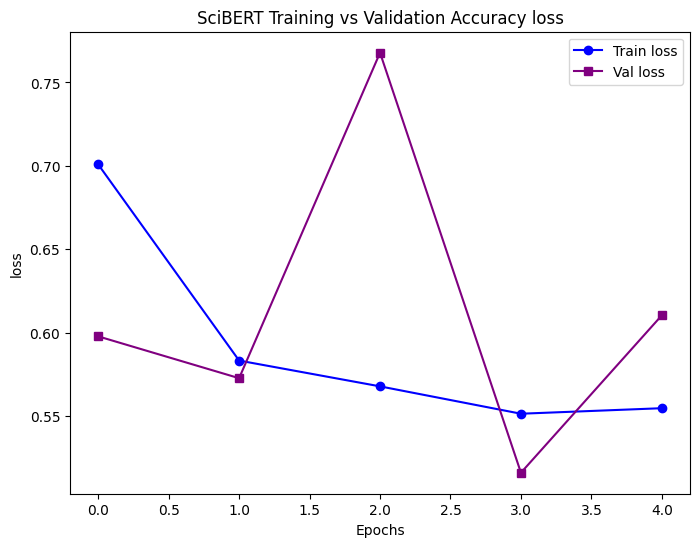

In [71]:
#SHOWS the fined tuned model training vs validation loss
plot_history(history, title='SciBERT Training vs Validation Accuracy')

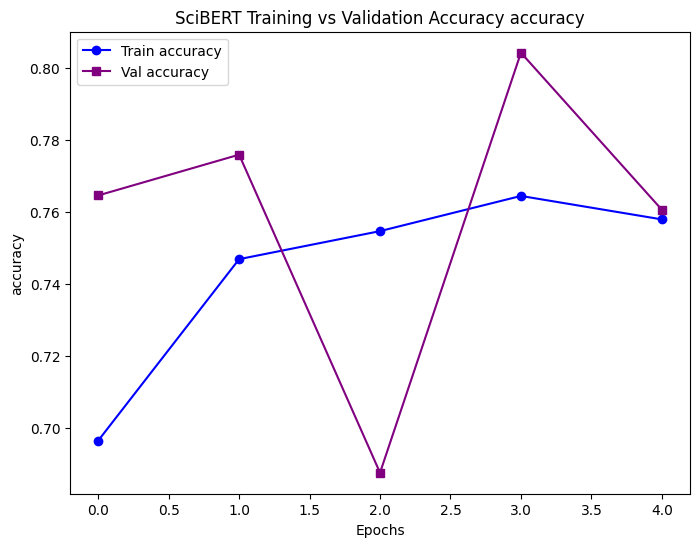

In [72]:
#SHOWS the fined tuned model training vs validation accuracy
plot_history(history, metric='accuracy', title='SciBERT Training vs Validation Accuracy')

In [73]:
#CHECKS test loss and accuracy
test_loss, test_acc = scibert.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

276/276 [==============================] - 23s 82ms/step - loss: 0.6205 - accuracy: 0.7382
Test Loss: 0.6205, Test Accuracy: 0.7382


In [74]:
#GETS predicted class labels from model outputs
predictions = scibert.predict(test_dataset)
logits = predictions.logits
pred_labels = tf.argmax(logits, axis=1).numpy()

276/276 [==============================] - 34s 112ms/step


In [75]:
#SHOWS classification report for scibert
print(classification_report(y_test_enc, pred_labels))

              precision    recall  f1-score   support

           0       0.90      0.67      0.77      1275
           1       0.73      0.80      0.76       631
           2       0.48      0.91      0.63       298

    accuracy                           0.74      2204
   macro avg       0.70      0.79      0.72      2204
weighted avg       0.79      0.74      0.75      2204



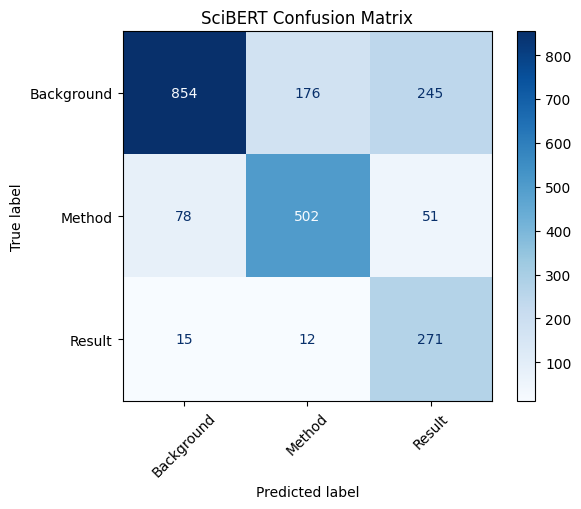

In [76]:
#SHOWS confusion matrix for scibert
plot_confusion_matrix(
    y_true=y_test_enc,
    y_pred=pred_labels,
    labels=[0, 1, 2],
    title="SciBERT Confusion Matrix"
)

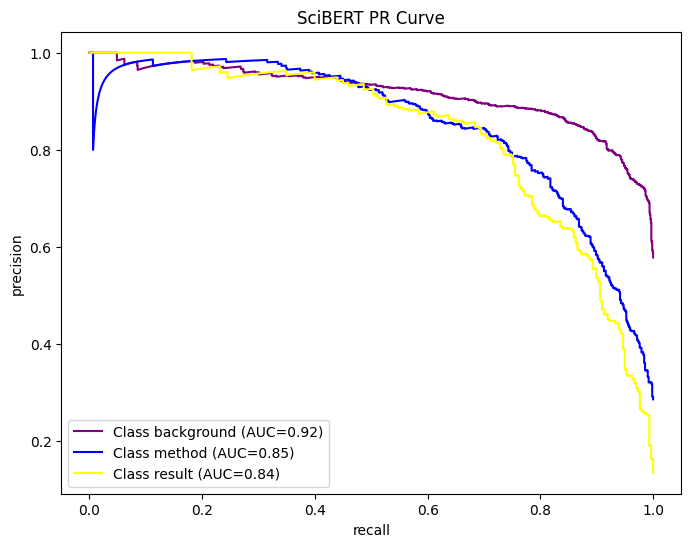

In [77]:
#SHOWS the one vs rest PR curve
all_logits = []
for batch in test_dataset:
    outputs = scibert(batch)
    batch_logits = outputs[0]
    all_logits.append(batch_logits)

logits = tf.concat(all_logits, axis=0)
y_scores_sci = softmax(logits, axis=1)
plot_precision_recall_curve(y_test_enc, y_scores_sci, title="SciBERT")

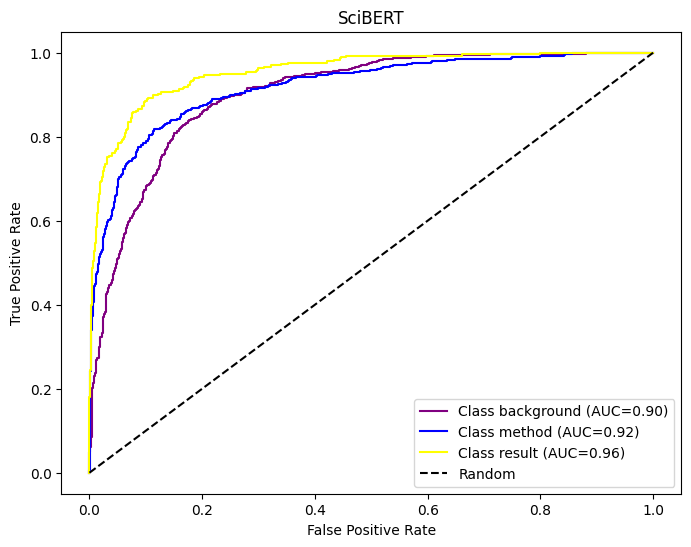

In [78]:
#SHOWS the roc-auc curve for scibert
plot_roc_auc_curve(y_test_enc, y_scores_sci, class_names=le.classes_, title="SciBERT")

In [79]:
#GIVES model internal flow
scibert.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109918464 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109920771 (419.31 MB)
Trainable params: 2307 (9.01 KB)
Non-trainable params: 109918464 (419.31 MB)
_________________________________________________________________


**The training and validation scores for both loss and accuracy is improving which means the model is generalizing after all layers except for classification layer was dropped out. In addition, even though the validation accuracy slightly fluctuated at mid-way, the F1-scores for each classes have increased and validation loss tends to decrease till the 5th epochs. Since the data is imbalanced, the priority lies to macro f1-score more than accuracy.**

----
----

# **Model Difference Validity Check** 📝

**McNemar Test is used to check whether the difference is statistically significant. The p-value evaluates the hypothesis.**
</br>
</br>
**H₀: Any performance difference is due to chance.**</br>
**H₁: The performance difference is statistically significant.**

In [80]:
#COMPUTES p-value to validate the statement
y_pred_scibert = []
y_pred_logreg = grid_search.best_estimator_.predict(X_test)
for i in range(0, len(X_test), 8):
    batch = tokenizer(X_test[i:i+8].tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")
    logits = scibert(batch)['logits']
    y_pred_scibert.extend(tf.argmax(logits, axis=1).numpy())

a = ((y_pred_logreg == y_test_enc) & (y_pred_scibert == y_test_enc)).sum()
b = ((y_pred_logreg == y_test_enc) & (y_pred_scibert != y_test_enc)).sum()
c = ((y_pred_logreg != y_test_enc) & (y_pred_scibert == y_test_enc)).sum()
d = ((y_pred_logreg != y_test_enc) & (y_pred_scibert != y_test_enc)).sum()

table = [[a, b],
         [c, d]]

result = mcnemar(table, exact=True)
print("p-value:", result.pvalue)

p-value: 0.0011267307308916003


**Since p-value is less than 0.05, the test successfully rejects the null hypothesis. This means that the difference between the models is statistically significantly.**

---
---

# **Model Download** 📩

In [81]:
#SAVES the Logistic regression model
joblib.dump(grid_search.best_estimator_, 'logreg_model.pkl')
files.download('logreg_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
#SAVES the sciBERT model
scibert.save_pretrained("scibert_model")
tokenizer.save_pretrained("scibert_model")
!zip -r scibert_model.zip scibert_model
files.download("scibert_model.zip")

  adding: scibert_model/ (stored 0%)
  adding: scibert_model/vocab.txt (deflated 52%)
  adding: scibert_model/special_tokens_map.json (deflated 42%)
  adding: scibert_model/config.json (deflated 51%)
  adding: scibert_model/tokenizer.json (deflated 71%)
  adding: scibert_model/tf_model.h5 (deflated 7%)
  adding: scibert_model/tokenizer_config.json (deflated 74%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

----
----

# **Thank you!!!** 😊